# GLASS plots

In this notebook all plots from the GLASS simulations are collected.

In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import camb
from cosmology import Cosmology
import pymaster as nmt
import glass.shells
import glass.fields
import healpy as hp
from matplotlib import pyplot, rcParams

nside = 1024
dx = 140
b = np.append(2**(np.arange(int(np.log(2*nside) / np.log(2)+1)))[1:], 3*nside)

pathGLASS =  f'/vol/aleph/data/mheld/salmo/GLASS_simulations/{nside}/'
pathFIGS_GLASS = f'../figs_thesis/GLASS_nside{nside}/'

if not os.path.exists(pathFIGS_GLASS):
    os.makedirs(pathFIGS_GLASS)
    
savefigs = True

Nsim = 100

## Matter shells

#### $C_l$'s of the matter shells

In [29]:
## define the cosmology
h = 0.7
Oc = 0.25
Ob = 0.05
ns = 0.965
A_s = 2e-09


# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2,
                       NonLinear=camb.model.NonLinear_both)
pars.InitPower.set_params(ns=ns)
# get the cosmology from CAMB
cosmology = Cosmology.from_camb(pars)

zb_cut = glass.shells.distance_grid(cosmology, 0,1, dx=dx)
nshells = len(zb_cut)-1

bins = nmt.NmtBin.from_edges(b[:-1], b[1:])
ells = bins.get_effective_ells()

maskSALMO = hp.ud_grade(hp.read_map(f'../maps_for_salmo/DECALS_mask.fits'), nside)

## workspace4
wsp = nmt.NmtWorkspace()
f = nmt.NmtField(maskSALMO, None, spin=0)
wsp.compute_coupling_matrix(f,f, bins)

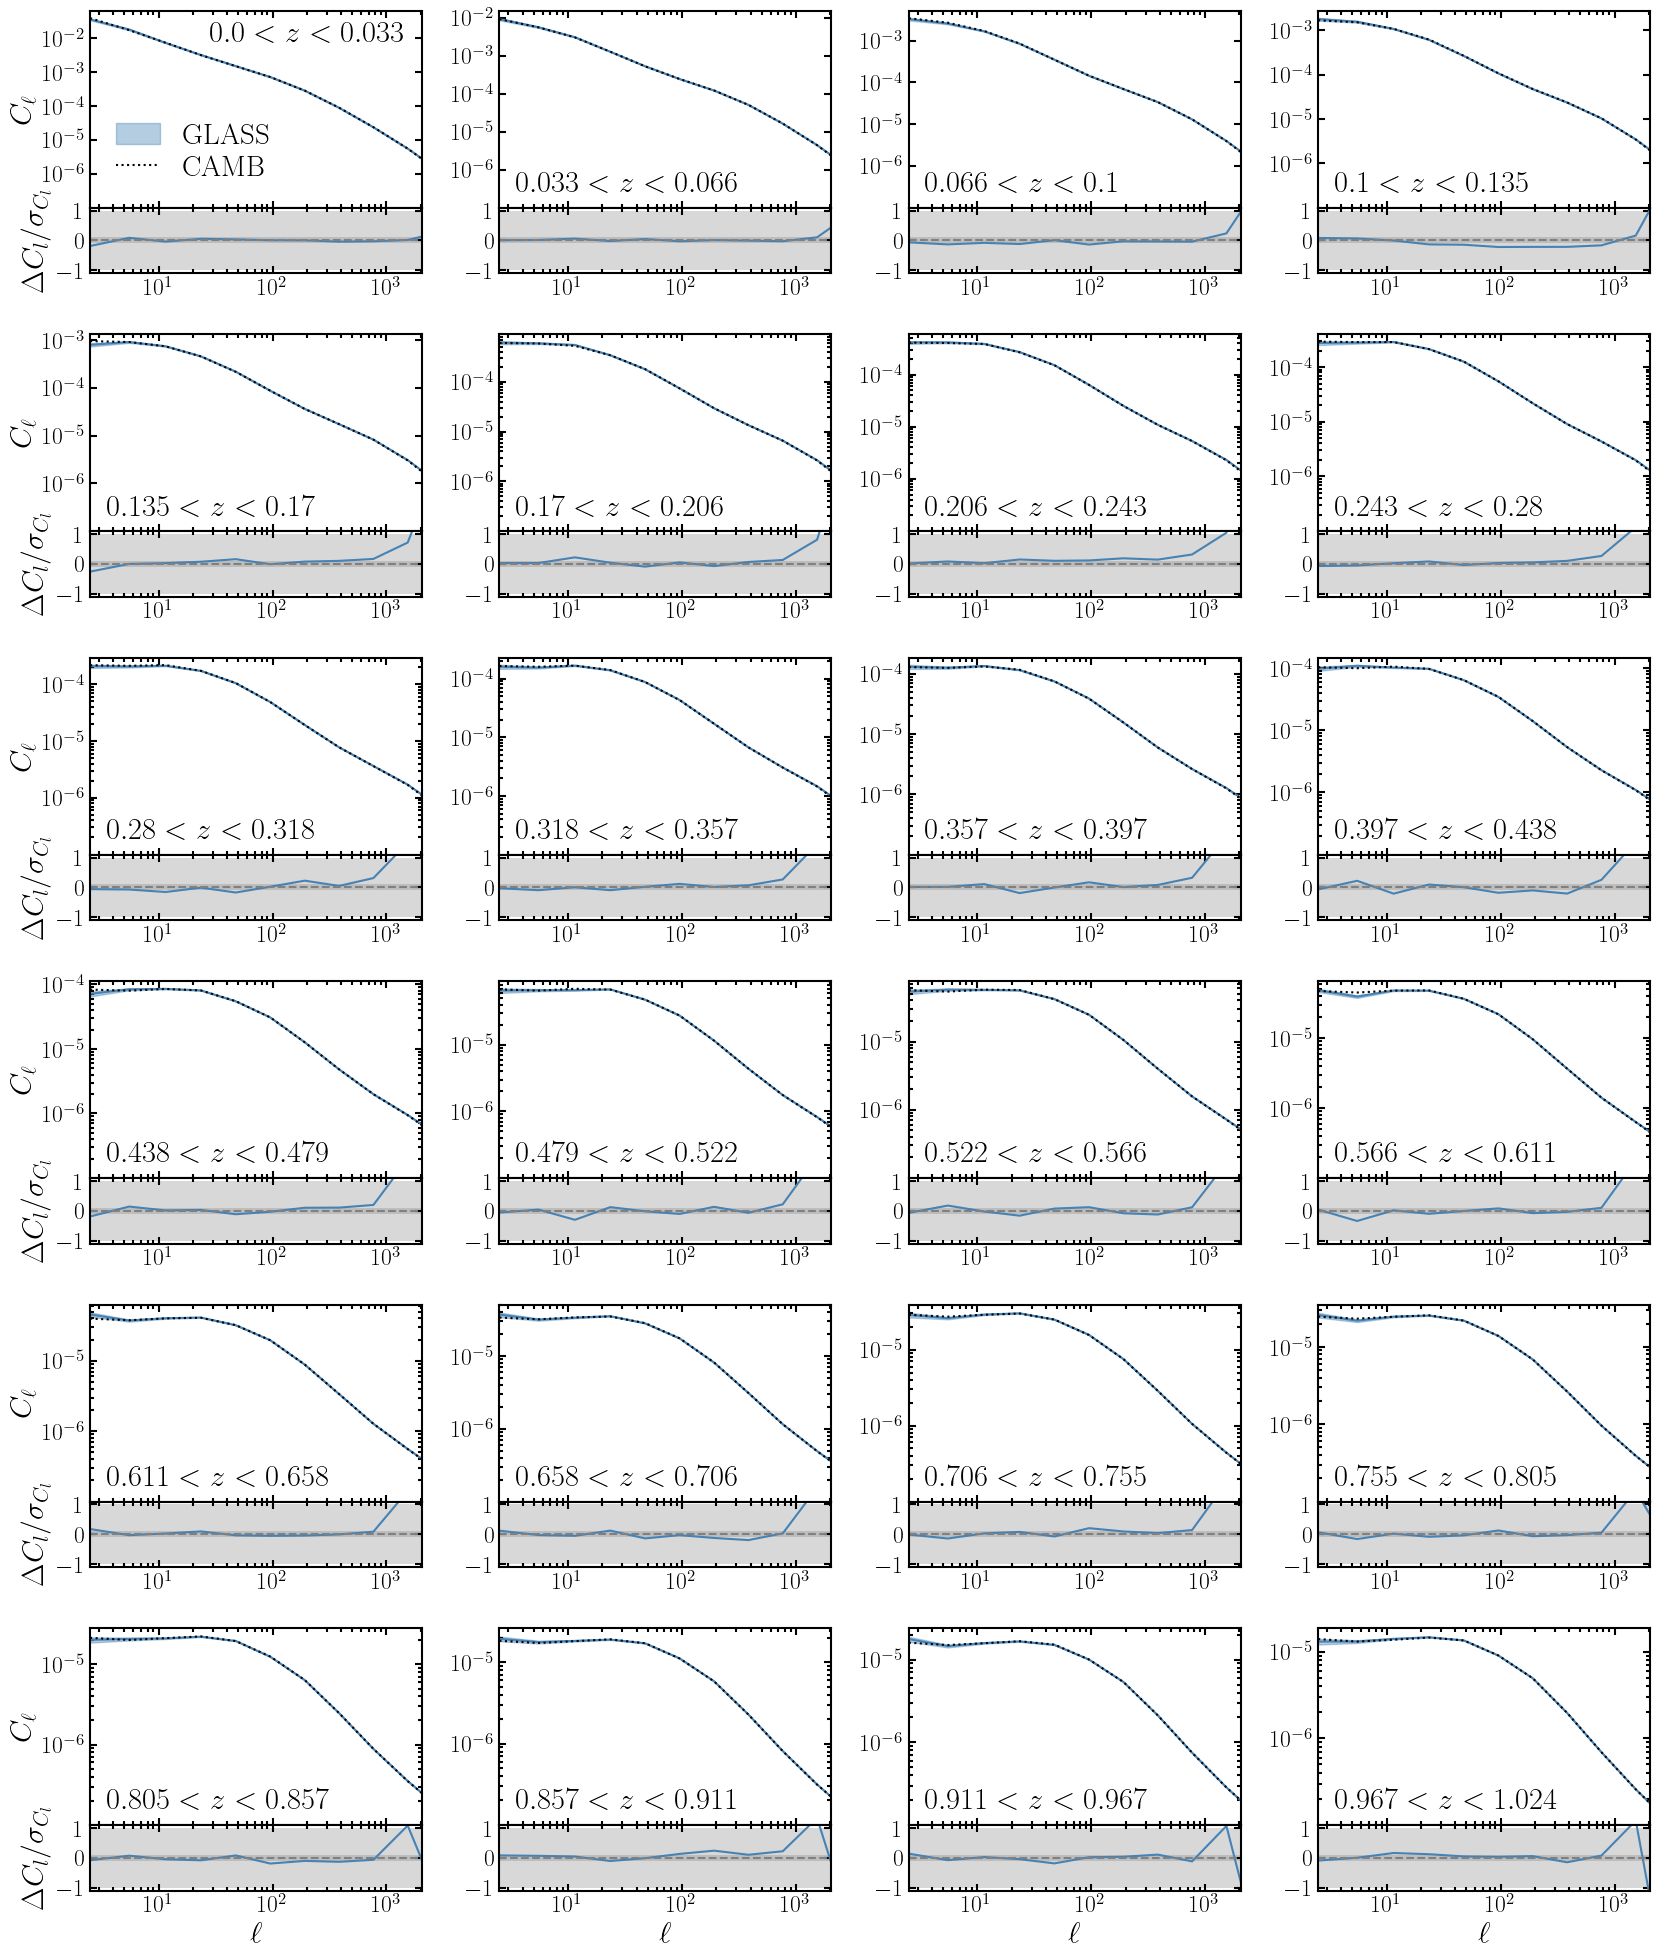

In [30]:
cls = pd.read_csv(f'{pathGLASS}ClsShells/mean_Cls.data')

fig = plt.figure(figsize=(17,20))
bands_grid = fig.add_gridspec(6,4)

cls_theo_arr = np.load(f'../theory/cls_dx140.npy')

theo_ind = 0
theo_add = 1
i = 0
for shell in range(nshells):
    plots_grid = bands_grid[shell//4, shell%4].subgridspec(2,1,hspace=0, height_ratios=[3,1])
    axs = plots_grid.subplots()

    ells = cls['ell']
    cls_theo_shells = glass.fields.getcl(cls_theo_arr, shell, shell)
    cls_theo_shells = wsp.decouple_cell(wsp.couple_cell(np.array([cls_theo_shells])))[0]   ## coupled/decoupled power spectrum


    cls_mean = cls[f'shell {shell+1}'].to_numpy()
    cls_unc = cls[f'shell {shell+1} unc'].to_numpy()
    
    axs[0].plot(ells, cls_mean, color='steelblue')
    axs[0].fill_between(ells, cls_mean - cls_unc, cls_mean + cls_unc, color='steelblue', alpha=0.4, label='GLASS')
    axs[0].plot(ells, cls_theo_shells, color='black', linestyle=':', label='CAMB')
    
    dev = (cls_mean - cls_theo_shells) / cls_unc / np.sqrt(Nsim)
    axs[1].plot(ells, dev, color='steelblue')

    if shell == 0:
        axs[0].text(.95,.95, f'${round(zb_cut[shell], 3)}<z<{round(zb_cut[shell+1], 3)}$', transform=axs[i].transAxes, horizontalalignment='right', verticalalignment='top', fontsize=22)
    else:
        axs[0].text(.05,.05, f'${round(zb_cut[shell], 3)}<z<{round(zb_cut[shell+1], 3)}$', transform=axs[i].transAxes, horizontalalignment='left', verticalalignment='bottom', fontsize=22)
    
    axs[0].set_yscale('log')
    axs[0].set_xscale('log')
    
    axs[0].set_xlim(ells[0],2*nside)
    axs[0].set_ylim(ymin=1e-7)
    
    if shell in [0,1]:
        axs[0].set_yticks([1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
    elif shell in [2,3,4]:
        axs[0].set_yticks([1e-3, 1e-4, 1e-5, 1e-6])
    elif shell in [5,6,7,8,9,10,11,12]:
        axs[0].set_yticks([1e-4, 1e-5, 1e-6])
    else:
        axs[0].set_yticks([1e-5, 1e-6])
        
    
    axs[1].axhline(0,ls='--', color='grey')
    axs[1].set_ylim(-1.1,1.1)
    axs[1].set_xscale('log')

    
    
    axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.3, color='grey', edgecolor=None)
    axs[1].fill_between(y1=-0.1, y2=0.1, x=ells, alpha=0.3, color='grey', edgecolor=None)
    axs[1].set_xlim(ells[0], 2*nside)
    
    if shell == 0:
        axs[0].legend(loc='lower left', frameon=False, fontsize=21)
    
    if shell in [20,21,22,23]:
        axs[1].set_xlabel(f'$\\ell$', fontsize=22)
    
    if shell in [0,4,8,12,16,20]:
        axs[0].set_ylabel(f'$C_\\ell$', fontsize=22)
        axs[1].set_ylabel('$\\Delta C_l / \\sigma_{C_l}$', fontsize=22)


#for i in np.arange(1, len(axs)//2-nshells):
#    axs[-i].axis('off')
#    axs[-i-5].axis('off')
#fig.suptitle('Pseudo $C_l$\'s for the simulated shells in GLASS (pixel window function added in GLASS and removed when calculating the PCL)', fontsize=30)
#plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.tight_layout()
if savefigs:
    plt.savefig(f'{pathFIGS_GLASS}Cls_MatterShells.png')
plt.show()

## Maps

/tmp/ipykernel_3520001/219865312.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


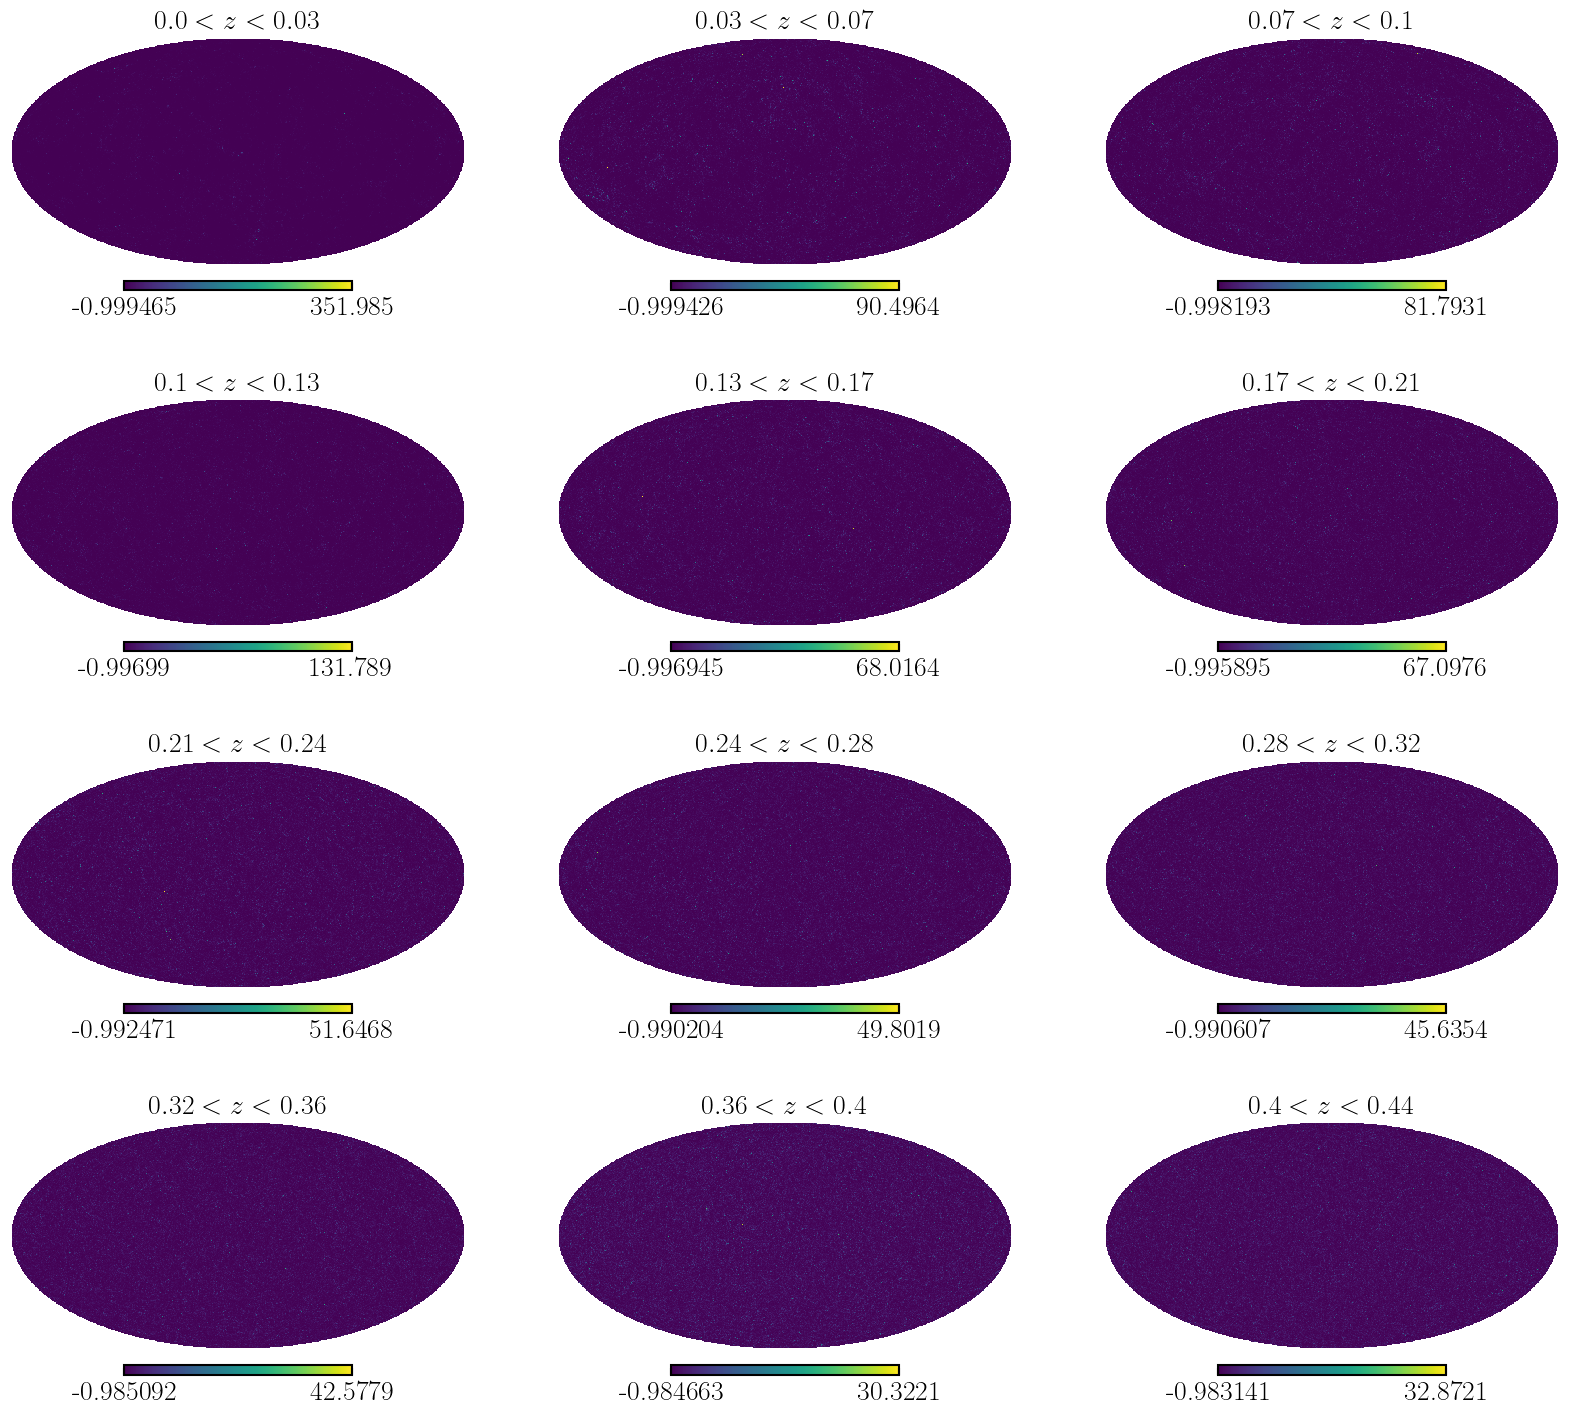

/tmp/ipykernel_3520001/219865312.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


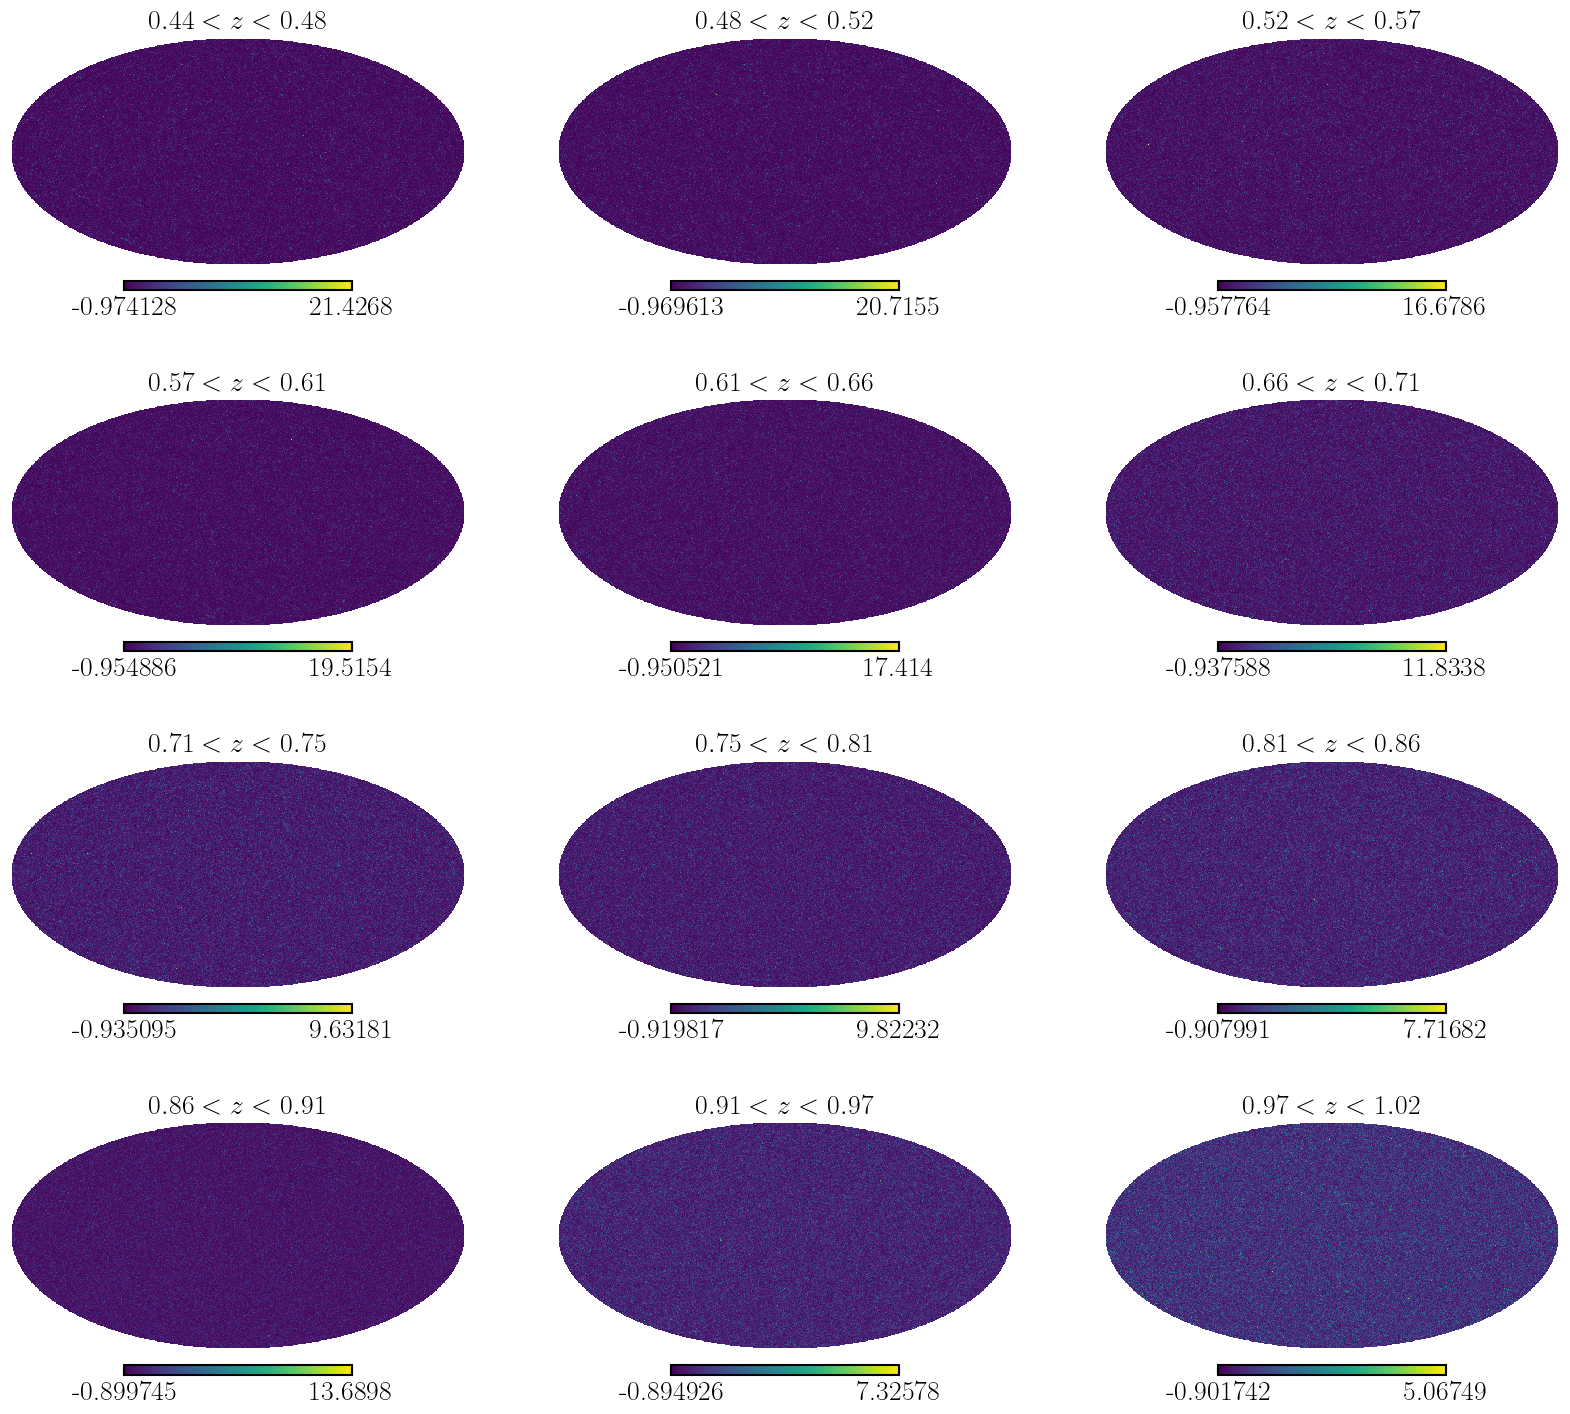

In [31]:
import matplotlib

fig1, ax1 = plt.subplots(ncols=3, nrows=4, figsize=(20,18))
ax1 = ax1.flatten()

matplotlib.rcParams.update({'font.size':20})
labelsize = 20

rcParams['axes.titlesize'] = 20

for i in range(12):
    shell = hp.read_map(f'{pathGLASS}MatterShells/DECALS_denMap_54_run2_f1z{i+1}.fits')
    
    plt.axes(ax1[i])
    hp.mollview(shell, title=f'${round(zb_cut[i], 2)} < z <{round(zb_cut[i+1], 2)}$', hold=True)
    fig = plt.gcf()  # Get current figure
    cbar = fig.axes[-1]  # The last axis is usually the colorbar
    cbar.tick_params(labelsize=labelsize)  # Set the fontsize of colorbar ticks

if savefigs:
    plt.tight_layout()
    plt.savefig(f'{pathFIGS_GLASS}MatterShells_p1.png')
plt.show()

fig2, ax2 = plt.subplots(ncols=3, nrows=4, figsize=(20,18))
ax2 = ax2.flatten()




for i in range(12):
    shell = hp.read_map(f'{pathGLASS}MatterShells/DECALS_denMap_54_run2_f1z{i+13}.fits')
    
    plt.axes(ax2[i])
    hp.mollview(shell, title=f'${round(zb_cut[i+12], 2)} < z <{round(zb_cut[i+1+12], 2)}$', hold=True)
    fig = plt.gcf()  # Get current figure
    cbar = fig.axes[-1]  # The last axis is usually the colorbar
    cbar.tick_params(labelsize=labelsize)  # Set the fontsize of colorbar ticks

if savefigs:
    plt.tight_layout()
    plt.savefig(f'{pathFIGS_GLASS}MatterShells_p2.png')
plt.show()

/tmp/ipykernel_3520001/1495030070.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


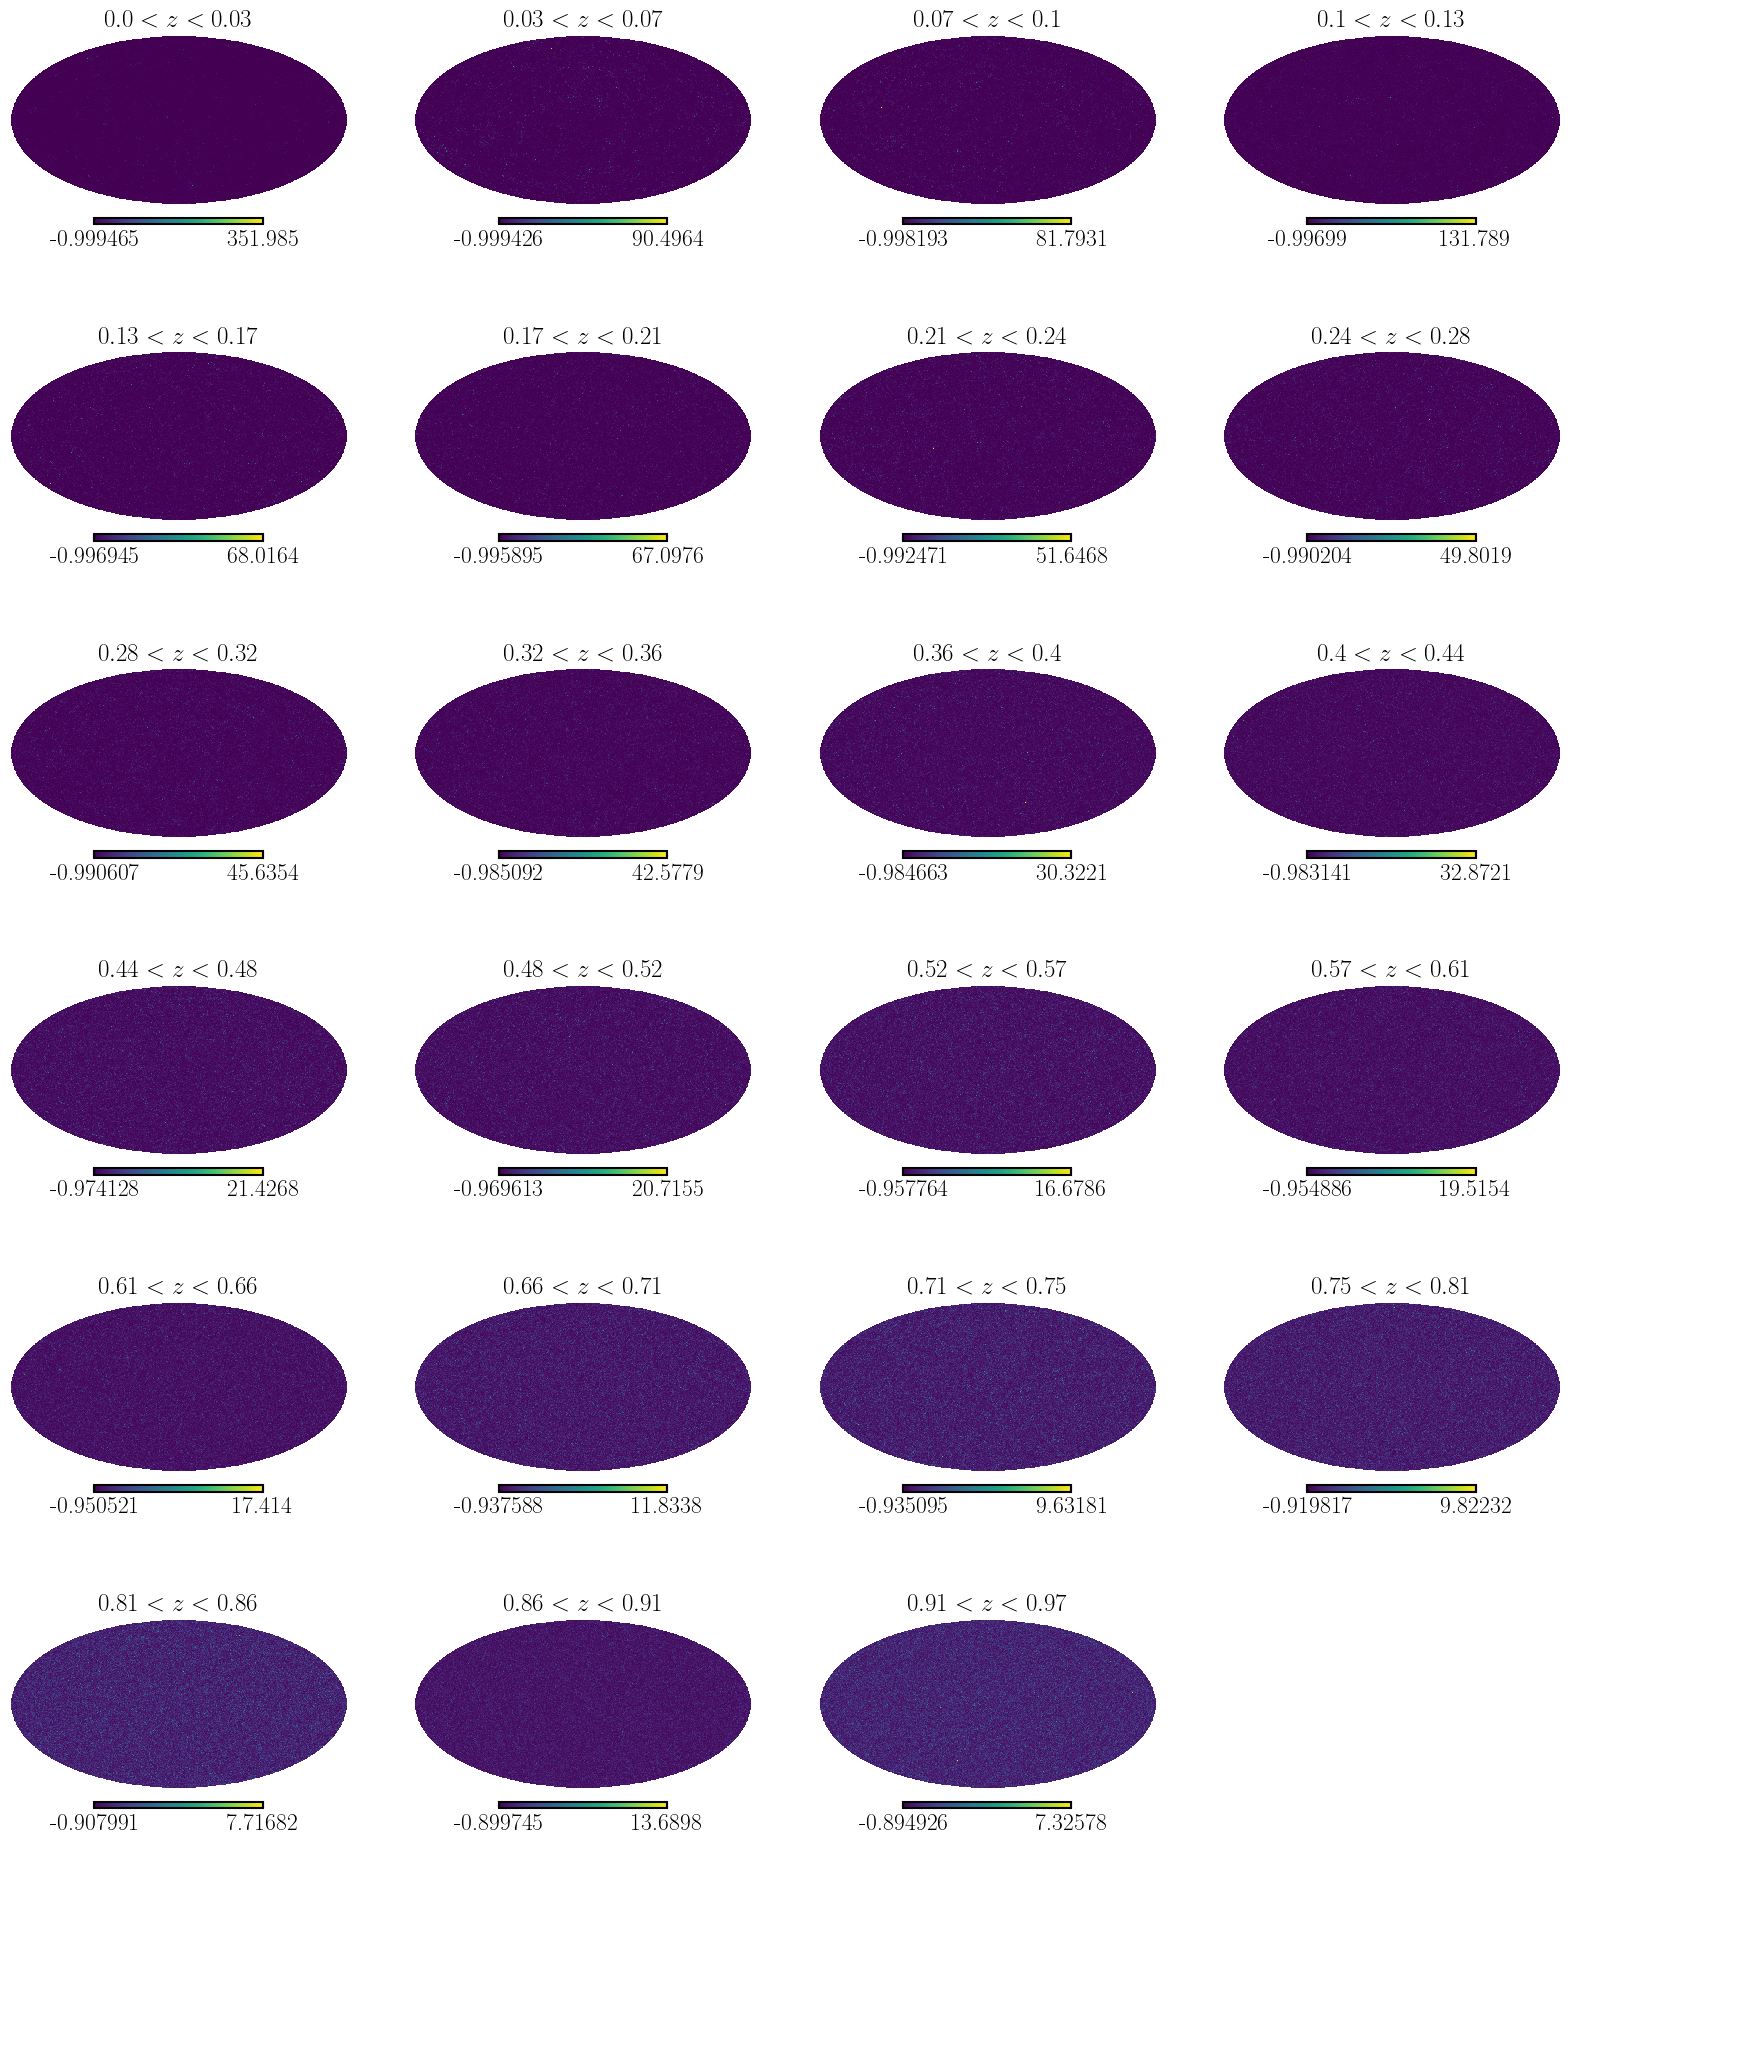

In [32]:
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(20,24))
ax = ax.flatten()
plt.axes(ax[0])

rcParams['axes.titlesize'] = 18

for i in range(nshells -1):
    shell = hp.read_map(f'{pathGLASS}MatterShells/DECALS_denMap_54_run2_f1z{i+1}.fits')
    
    plt.axes(ax[i])
    hp.mollview(shell, title=f'${round(zb_cut[i], 2)} < z <{round(zb_cut[i+1], 2)}$', hold=True)
ax[-1].axis('off')
if savefigs:
    plt.tight_layout()
    plt.savefig(f'{pathFIGS_GLASS}MatterShells.png')
plt.show()
    

## Projection of the matter shells


#### $C_l$'s of the projected matter shells

In [33]:
cls_true = np.load('../theory/cls_theory_ccl.npy')
cls_theo = wsp.decouple_cell(wsp.couple_cell([cls_true]))[0]   ## coupled/decoupled power spectrum

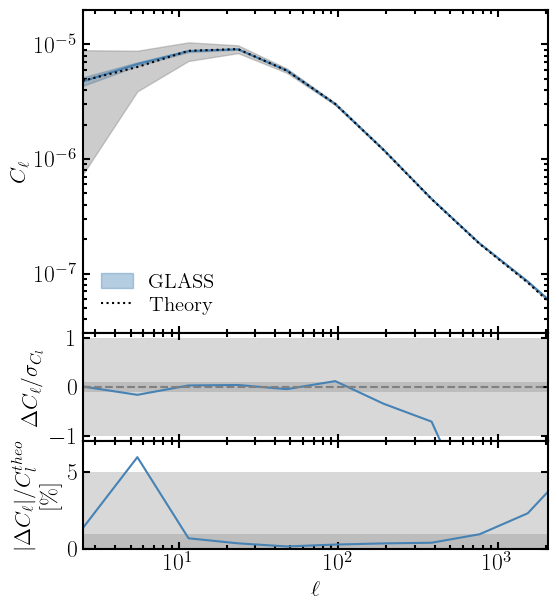

In [34]:
cls = pd.read_csv(f'{pathGLASS}ClsGLASS/mean_Cls.data')


ells = cls['ell'].to_numpy()
cls_mean = cls[f'Cls'].to_numpy()
cls_unc = cls[f'Cls unc'].to_numpy()

fig = plt.figure(figsize=(6,7))
fig_grid = fig.add_gridspec(1,1)

plots_grid = fig_grid[0,0].subgridspec(3,1,hspace=0, height_ratios=[3,1,1])
axs = plots_grid.subplots()

axs[0].plot(ells, cls_mean, color='steelblue')
axs[0].fill_between(ells, cls_mean- cls_unc, cls_mean+ cls_unc, color='steelblue', alpha=0.4, label='GLASS')
axs[0].plot(ells, cls_theo, color='black', linestyle=':', label='Theory')
axs[0].fill_between(ells, cls_theo- cls_unc*np.sqrt(Nsim), cls_theo+ cls_unc*np.sqrt(Nsim), color='grey', alpha=0.4)

axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel(f'$C_\\ell$', fontsize=16)
axs[0].legend(loc='lower left', frameon=False)
axs[0].set_xlim(ells[0], 2*nside)
axs[0].set_ylim(3e-8, 2e-5)

dev = (cls_theo - cls_mean) / cls_unc / np.sqrt(Nsim)
axs[1].plot(ells, dev, color='steelblue')

axs[1].axhline(0,ls='--', color='grey')
axs[1].set_ylabel('$\\Delta C_\\ell /\\sigma_{C_l}$', fontsize=16)
axs[1].fill_between(y1=-1, y2=1, x=ells, alpha=0.3, color='grey', edgecolor=None)
axs[1].fill_between(y1=-.1, y2=.1, x=ells, alpha=0.3, color='grey', edgecolor=None)
axs[1].set_ylim(-1.1,1.1)
axs[1].set_xlabel(f'$\\ell$', fontsize=16)
axs[1].set_xscale('log')
axs[1].set_xlim(ells[0],2*nside)


dev = abs(cls_theo - cls_mean) / cls_theo * 100
axs[2].plot(ells, dev, color='steelblue')

axs[2].axhline(0,ls='--', color='grey')
axs[2].set_ylabel('$|\\Delta C_\\ell| /C_l^{theo}$ \n [\\%]', fontsize=16)
axs[2].fill_between(y1=0, y2=5, x=ells, alpha=0.3, color='grey', edgecolor=None)
axs[2].fill_between(y1=-3, y2=1, x=ells, alpha=0.3, color='grey', edgecolor=None)
axs[2].set_ylim(0,7)
#axs[1].set_xlabel(f'$\\ell$', fontsize=16)
axs[2].set_xlabel(f'$\\ell$', fontsize=16)
axs[2].set_xscale('log')
axs[2].set_xlim(ells[0],2*nside)
if savefigs:
    plt.savefig(f'{pathFIGS_GLASS}Cls_GLASSprojection.png')
plt.show()

#### Projected matter overdensity

/tmp/ipykernel_3520001/1330047139.py:10: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


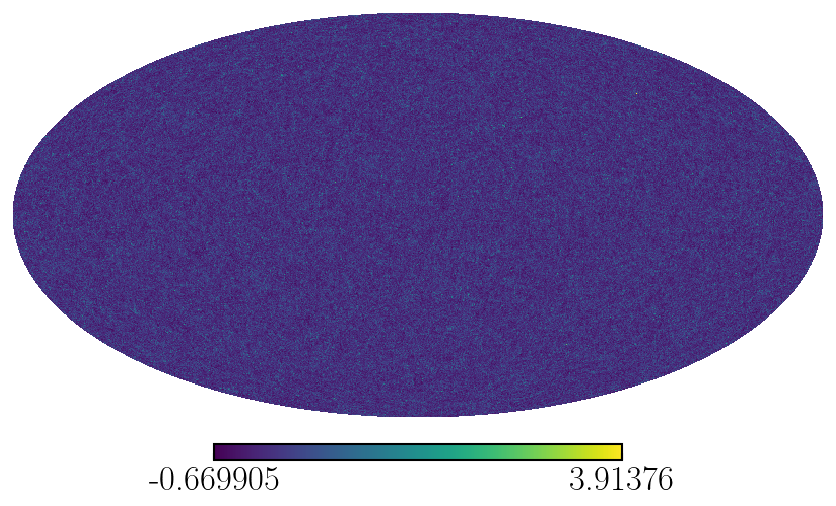

In [35]:
map = hp.read_map(f'{pathGLASS}MatterDensMaps/GLASS_map_1.fits')

hp.mollview(map, title='')

fig = plt.gcf()  # Get current figure
cbar = fig.axes[-1]  # The last axis is usually the colorbar
cbar.tick_params(labelsize=25)  # Set the fontsize of colorbar ticks

if savefigs:
    plt.tight_layout()
    plt.savefig(f'{pathFIGS_GLASS}ProjectedMatterShells.png')
plt.show()